# Predicting house prices using k-nearest neighbors regression
In this notebook, you will implement k-nearest neighbors regression. You will:
  * Find the k-nearest neighbors of a given query input
  * Predict the output for the query input using the k-nearest neighbors
  * Choose the best value of k using a validation set

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Load Data

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data_small.csv', dtype=dtype_dict)
sales

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8698,0844000965,20140626T000000,224000.0,3.0,1.75,1500.0,11968,1.0,0,0,...,6,1500,0,2014,0,98010,47.3095,-122.002,1320.0,11303.0
8699,7852140040,20140825T000000,507250.0,3.0,2.50,2270.0,5536,2.0,0,0,...,8,2270,0,2003,0,98065,47.5389,-121.881,2270.0,5731.0
8700,9834201367,20150126T000000,429000.0,3.0,2.00,1490.0,1126,3.0,0,0,...,8,1490,0,2014,0,98144,47.5699,-122.288,1400.0,1230.0
8701,3448900210,20141014T000000,610685.0,4.0,2.50,2520.0,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520.0,6023.0


# Import useful functions from previous notebooks

In [3]:
def get_numpy_data(data_frame, features, output):
    data_frame['constant'] = 1 # this is how you add a constant column to data frame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):

    # the following line will convert the features and output into a numpy matrix:
    features_df = data_frame[features]
    feature_matrix = features_df.to_numpy()
   
    output_df = data_frame[output]
    output_array = output_df.to_numpy()

    return(feature_matrix, output_array)

In [4]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = feature_matrix/norms
    return normalized_features, norms

# Split data into training, test, and validation sets

In [5]:
testing = pd.read_csv('kc_house_data_small_test.csv', dtype=dtype_dict)
training = pd.read_csv('kc_house_data_small_train.csv', dtype=dtype_dict)
validation = pd.read_csv('kc_house_data_validation.csv', dtype=dtype_dict)

# Extract features and normalize

In [6]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']

features_train, output_train = get_numpy_data(training, feature_list, 'price')
features_test, output_test = get_numpy_data(testing, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

In computing distances, it is crucial to normalize features. Otherwise, for example, the `sqft_living` feature (typically on the order of thousands) would exert a much larger influence on distance than the `bedrooms` feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.

IMPORTANT: Make sure to store the norms of the features in the training set. The features in the test and validation sets must be divided by these same norms, so that the training, test, and validation sets are normalized consistently.

In [7]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

# Compute a single distance

To start, let's just explore computing the "distance" between two given houses.  We will take our **query house** to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

To see the features associated with the query house, print the first row (index 0) of the test feature matrix. You should get an 18-dimensional vector whose components are between 0 and 1.

In [8]:
features_test[0]

array([ 0.01345102,  0.01551285,  0.01807473,  0.01759212,  0.00160518,
        0.017059  ,  0.        ,  0.05102365,  0.0116321 ,  0.01564352,
        0.01362084,  0.02481682,  0.01350306,  0.        ,  0.01345387,
       -0.01346922,  0.01375926,  0.0016225 ])

In [9]:
features_train[9]

array([ 0.01345102,  0.01163464,  0.00602491,  0.0083488 ,  0.00050756,
        0.01279425,  0.        ,  0.        ,  0.01938684,  0.01390535,
        0.0096309 ,  0.        ,  0.01302544,  0.        ,  0.01346821,
       -0.01346251,  0.01195898,  0.00156612])

What is the Euclidean distance between the query house and the 10th house of the training set? 

Note: Do not use the `np.linalg.norm` function; use `np.sqrt`, `np.sum`, and the power operator (`**`) instead. The latter approach is more easily adapted to computing multiple distances at once.

In [10]:
np.sqrt(sum((features_test[0]-features_train[9])**2))

0.05972359371398078

# Compute multiple distances

Of course, to do nearest neighbor regression, we need to compute the distance between our query house and *all* houses in the training set.  

To visualize this nearest-neighbor search, let's first compute the distance from our query house (`features_test[0]`) to the first 10 houses of the training set (`features_train[0:10]`) and then search for the nearest neighbor within this small set of houses.  Through restricting ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.

Write a loop to compute the Euclidean distance from the query house to each of the first 10 houses in the training set.

In [11]:
for i in range(10):
    d = np.sqrt(sum((features_test[0]-features_train[i])**2))
    print(d)

0.06027470916295592
0.08546881147643746
0.06149946435279315
0.05340273979294363
0.05844484060170442
0.059879215098128345
0.05463140496775461
0.05543108323614607
0.052383627840220305
0.05972359371398078


# Perform 1-nearest neighbor regression

Now that we have the element-wise differences, it is not too hard to compute the Euclidean distances between our query house and all of the training houses. First, write a single-line expression to define a variable `diff` such that `diff[i]` gives the element-wise difference between the features of the query house and the `i`-th training house.

In [12]:
diff = features_train[:] - features_test[0]
print(diff[-1].sum()) # sum of the feature differences between the query and last training house
# should print -0.0934339605842

-0.09343399874654643


The next step in computing the Euclidean distances is to take these feature-by-feature differences in `diff`, square each, and take the sum over feature indices.  That is, compute the sum of square feature differences for each training house (row in `diff`).

By default, `np.sum` sums up everything in the matrix and returns a single number. To instead sum only over a row or column, we need to specifiy the `axis` parameter described in the `np.sum` [documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.sum.html). In particular, `axis=1` computes the sum across each row.

Below, we compute this sum of square feature differences for all training houses and verify that the output for the 16th house in the training set is equivalent to having examined only the 16th row of `diff` and computing the sum of squares on that row alone.

In [14]:
print(np.sum(diff**2, axis=1)[15]) # take sum of squares across each row, and print the 16th sum
print(np.sum(diff[15]**2)) # print the sum of squares for the 16th row -- should be same as above

0.0033070590284564457
0.0033070590284564453


With this result in mind, write a single-line expression to compute the Euclidean distances between the query house and all houses in the training set. Assign the result to a variable `distances`.

**Hint**: Do not forget to take the square root of the sum of squares.

In [16]:
distances = np.sqrt(np.sum(diff**2, axis=1))
print(distances)
distances.argmin()

[0.06027471 0.08546881 0.06149946 ... 0.05716729 0.05705739 0.05846758]


3758

In [17]:
output_train[3758]

635000.0

# Perform k-nearest neighbor regression

For k-nearest neighbors, we need to find a *set* of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.

## Fetch k-nearest neighbors

Using the functions above, implement a function that takes in
 * the value of k;
 * the feature matrix for the training houses; and
 * the feature vector of the query house
 
and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.

**Hint**: Look at the [documentation for `np.argsort`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html).

In [18]:
list = distances.argsort()
list[3]

5038

## Make a single prediction by averaging k nearest neighbor outputs

Now that we know how to find the k-nearest neighbors, write a function that predicts the value of a given query house. **For simplicity, take the average of the prices of the k nearest neighbors in the training set**. The function should have the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature vector of the query house, whose price we are predicting.
 
The function should return a predicted value of the query house.

**Hint**: You can extract multiple items from a Numpy array using a list of indices. For instance, `output_train[[6, 10]]` returns the prices of the 7th and 11th training houses.

In [19]:
def knn(k, features_train, output_train, features_query):
    diff = features_train[:] - features_query
    distance = np.sqrt(np.sum(diff**2, axis=1))
    list = distance.argsort()
    result = 0
    
    for i in range(k):
        result += output_train[list[i]]
    
    return result/k

In [20]:
knn(4, features_train, output_train, features_test[2])

413987.5

## Make multiple predictions

Write a function to predict the value of *each and every* house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function should take the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature matrix for the query set.
 
The function should return a set of predicted values, one for each house in the query set.

**Hint**: To get the number of houses in the query set, use the `.shape` field of the query features matrix. See [the documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.ndarray.shape.html).

In [21]:
def knn_all(k, features_train_matrix, output_train_matrix, features_test_matrix, n):
    for i in range(n): 
        result = knn(10, features_train_matrix, output_train_matrix, features_test_matrix[i])
        print([i,result])

In [22]:
knn_all(10,features_train, output_train, features_test, 10)

[0, 881300.0]
[1, 431860.0]
[2, 460595.0]
[3, 430200.0]
[4, 766750.0]
[5, 667420.0]
[6, 350032.0]
[7, 512800.7]
[8, 484000.0]
[9, 457235.0]


## Choosing the best value of k using a validation set

There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. Write a loop that does the following:

* For `k` in [1, 2, ..., 15]:
    * Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
    * Computes the RSS for these predictions on the VALIDATION set
    * Stores the RSS computed above in `rss_all`
* Report which `k` produced the lowest RSS on VALIDATION set.

In [23]:
rss_all=[]
for k in range(1,16):
    rss=0
    for i in range(features_valid.shape[0]):
        predict = knn(k, features_train, output_train, features_valid[i])
        rss = rss + (predict-output_valid[i])**2    
    rss_all.append(rss)
    
    print([k, rss*1E-14])

[1, 1.05453830251561]
[2, 0.834450735040255]
[3, 0.726920960192028]
[4, 0.7194672165209168]
[5, 0.6984651741971859]
[6, 0.688995443531811]
[7, 0.6834197345005105]
[8, 0.673616787354915]
[9, 0.6837272795897633]
[10, 0.693350486685567]
[11, 0.6952385521559887]
[12, 0.6904996958724645]
[13, 0.7001125450826362]
[14, 0.7090869886903444]
[15, 0.7110692838594536]


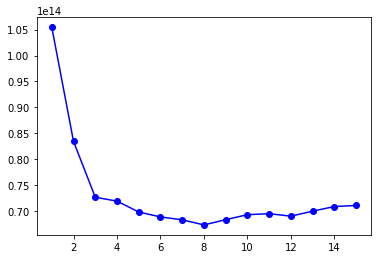

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')